In [ ]:
# 2020 Ben Gladders
# Adapted from Deitel.P, Deitel.H (2020) Multi-Classification with the MNIST Dataset.
# In: Intro to Python for Computer Science and Data Science. pp.666-709

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

from datetime import datetime
from PIL import Image
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pydot

print("TensorFlow version: ", tf.__version__)
# assert version.parse(tf.__version__).release[0] >= 2, \
#    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.1.0


In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16796730319216316659
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9204972913
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1093157001860121119
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
%load_ext tensorboard
# Tensorboard for realtime graphing.

logdir= Path('logs/fit/') / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 12752), started 1:47:12 ago. (Use '!kill 12752' to kill it.)

In [17]:
%matplotlib inline

image_generator = image.ImageDataGenerator(rescale=1./255, rotation_range=360,
                                                     width_shift_range=0.3,
                                                     height_shift_range=0.3,
                                                     channel_shift_range=0.5,
                                                     brightness_range=(.2,1.8),
                                                     shear_range=20,
                                                     zoom_range=.15,
                                                     fill_mode='nearest',
                                                     horizontal_flip=True,
                                                     vertical_flip=True, validation_split=0.1)
# rescale normalises data to 0-1(float) range.

In [18]:
BATCH_SIZE = 128
IMG_HEIGHT = 100
IMG_WIDTH = 100
NUM_EPOCHS = 40
train_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Training-new')
test_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Test-new')
real_data_dir = Path('C:/Users/bengl/Pictures/fruits-360/Real-new')
# Path() ensures script runs on windows and linux - sorts '/''\'mismatch in OS

In [19]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical',
                                                     subset='training')
                                                     # color_mode='grayscale')

Found 2190 images belonging to 5 classes.


In [20]:
valid_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical',
                                                     subset='validation')
                                                     # color_mode='grayscale')

Found 241 images belonging to 5 classes.


In [21]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical')
                                                     # color_mode='grayscale')

Found 816 images belonging to 5 classes.


([<matplotlib.patches.Wedge at 0x22dbcd83588>,
 [Text(-0.5992360444127869, 0.9815376523987844, 'Train'),
  Text(-0.27492204797149944, -1.1166547664964122, 'Validation'),
  Text(0.809822171737824, -0.8165096754857437, 'Test')],
 [Text(-0.3386986337985316, 0.5547821513558346, '67.4%'),
  Text(-0.15539072276649968, -0.6311526941066676, '7.4%'),
  Text(0.45772557533007435, -0.4615054687528116, '25.1%')])

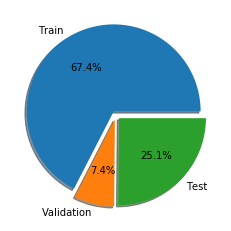

In [22]:
plt.pie([train_data_gen.samples,
         valid_data_gen.samples,
         test_data_gen.samples],
         labels=['Train','Validation', 'Test'],
         explode=(0.05,0.05, 0.05),
         shadow=True,
         autopct='%1.1f%%')

In [23]:
def print_fruit_type(dataset, item_number):
    for item in dataset.class_indices.items():
        if item[1] == dataset.classes[item_number]:
           print('Fruit %d is type: %s' % ( item_number, item[0]))

In [24]:
print_fruit_type(train_data_gen,100)

Fruit 100 is type: Avocado ripe


In [25]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(np.where(label_batch[n]==1)[0][0])
      plt.axis('off')

In [26]:
image_batch, label_batch = next(train_data_gen)  # load next batch into variables for inspection

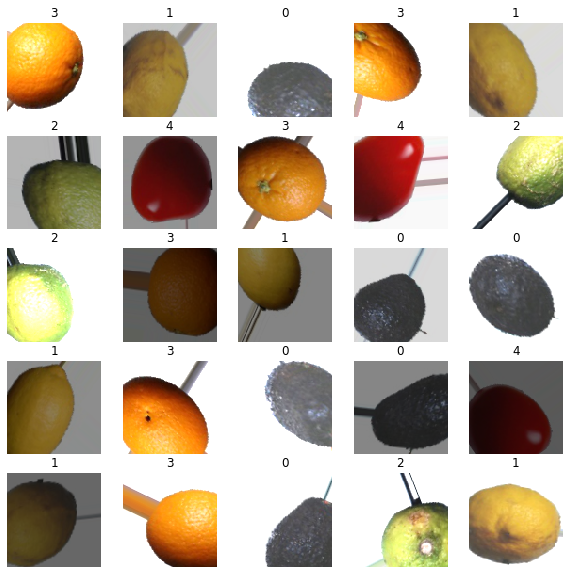

In [27]:
show_batch(image_batch, label_batch)

In [28]:
image_batch.shape # assure data shape is ideal.. 4D tensor [fruit_sample_no, y, x, (r,g, or b)]

(128, 100, 100, 3)

In [29]:
label_batch.shape # [BATCH_SIZE]labels, of 120 fruit options

(128, 5)

In [30]:
image = image_batch[0][50][50][0]  # get red values at pos 50,50
image

0.9921569

In [31]:
label_batch[0]  # display category number for batch_size[fruit_no]

array([0., 0., 0., 1., 0.], dtype=float32)

In [32]:
np.where(label_batch[0]==1)[0][0] # displays category as int

3

In [33]:
cnn = Sequential()  # Instantiate tensorflow model then add layers

In [34]:
cnn.add(Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu', # rectified linear unit - any neg value will be set 0. Positive values remain unchanged.
               input_shape=(100, 100, 3)))

In [35]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [36]:
cnn.add(Conv2D(filters=128,
               kernel_size=(5, 5),
               activation='relu'))

In [37]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [38]:
cnn.add(Flatten())

In [39]:
cnn.add(Dense(units=128,
              activation='relu'))  # dense layers have all previous nodes connected to each node in the layer

In [40]:
cnn.add(Dense(units=5,
              activation='softmax'))

In [41]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7929984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [42]:
#plot_model(cnn, to_file='convnet.png') # cannot get graphviz to work.
#installed stand alone version for windows.
#edited pydot python file path to gvedit.exe
#InvocationException: Program terminated with status: 3221225477. stderr follows: Qt: Untested Windows version 6.2 detected!
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe: illegal option -- 'T'
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe : option -T unrecognized - ignored
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe: illegal option -- 'p'
#D:\Anaconda\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz\gvedit.exe : option -p unrecognized - ignored
#Image(filename='convnet.png')  # display resulting image in notebook

In [43]:
cnn.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [44]:
STEPS_PER_EPOCH = np.ceil(train_data_gen.samples/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(valid_data_gen.samples/BATCH_SIZE)
TEST_STEPS_PER_EPOCH = np.ceil(test_data_gen.samples/BATCH_SIZE)
print('Batch size: %d' %BATCH_SIZE)
print('Steps per Epoch: %d' %STEPS_PER_EPOCH)
print('Test Steps per Epoch: %d' %TEST_STEPS_PER_EPOCH)
# auto calculation of steps per epoch, requiring only batch size and no_epochs to be set. Avoids data depletion.

Batch size: 128
Steps per Epoch: 18
Test Steps per Epoch: 7


In [45]:
cnn.fit(train_data_gen, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCHS, validation_data=valid_data_gen, validation_steps=VAL_STEPS_PER_EPOCH, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18.0 steps, validate for 2.0 steps
Epoch 1/40
 1/18 [>.............................] - ETA: 33s

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-45-175ab381043c>:1) ]] [Op:__inference_distributed_function_867]

Function call stack:
distributed_function


In [ ]:
loss, accuracy = cnn.evaluate(test_data_gen,
                              steps=TEST_STEPS_PER_EPOCH,
                              verbose =1)

In [ ]:
print('Loss = %s' %loss)
print('Accuracy = %s' %accuracy)

In [ ]:
# Seif.G (2019) Available from 
# https://towardsdatascience.com/visualising-filters-and-feature-maps-for-deep-learning-d814e13bd671
# Show weights
layer_dict = dict([(layer.name, layer) for layer in cnn.layers])

layer_name = 'conv2d'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

# Normalize filter values to a range of 0 to 1 so we can visualize them
f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters - f_min) / (f_max - f_min)

# Plot first few filters
n_filters, index = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):

        ax = plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, j], cmap='viridis')
        index += 1
        
plt.show()

In [ ]:
real_data_gen = image_generator.flow_from_directory(directory=str(real_data_dir),
                                                     batch_size=7,
                                                     shuffle=True,
                                                     target_size=(100, 100),
                                                     classes = None,
                                                     class_mode='categorical')

In [ ]:
image, label = next(real_data_gen)  # test on pictures of fruit from home

In [ ]:
predictions = cnn.predict(real_data_gen)

In [46]:
count =0
for item in predictions:
    print('Photo %d predicted as %d, actual was %d' % (count, np.argmax(item), np.argmax(label[count])))
    count+=1

NameError: name 'predictions' is not defined

In [ ]:
cnn.save('current.h5')  # save machine learning state